In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import matplotlib.pylab aNs plt
np.set_printoptions(precision=2)

# Téma 8: Unscented Kalman filter (UKF)

Myšlenka tzv. [*unscented transformace*](https://en.wikipedia.org/wiki/Unscented_transform), tj. diskrétní reprezentace nějaké distribuce pomocí vhodně vybraných bodů (zvaných *sigma-body*) a její využití v kalmanovské filtraci se datuje do 90. let. Autory jsou [Jeffrey Uhlmann](https://en.wikipedia.org/wiki/Jeffrey_Uhlmann) (nejen matematik, ale také herec a hudebník) a Simon Julier.

[UKF](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter) je často mnohem snazší nasadit na reálné problémy, než [EKF](https://en.wikipedia.org/wiki/Extended_Kalman_filter). Navíc dává v praxi srovnatelnou či lepší kvalitu odhadů, z hlediska teorie poskytuje lepší aproximaci než EKF. Stejně jako EKF ale není optimální ve smyslu minimalizace [střední kvadratické chyby](https://en.wikipedia.org/wiki/Minimum_mean_square_error).

# Motivace

Předpokládejme stavový model ve tvaru

$$
\begin{align}
x_t &= f_t(x_{t-1}, u_t) + w_t, \\
y_t &= h_t(x_t) + v_t,
\end{align}
$$

kde
- $x_t$ je neznámý stav
- $y_t$ pozorovaná veličina (měření)
- $w_t\sim (0,Q_t)$ nepozorovaný centrovaný iid šum stavu (procesu) s kovariancí $Q_t$
- $v_t \sim (0,R_t)$ nepozorovaný centrovaný iid šum modelu (pozorování, měření) s kovariancí $R_t$
- $u_t$ externí veličina (regresor, vstup, řídící veličina)
- $f_t$ a $h_t$ jsou **nelineární funkce**.

Rozšířený Kalmanův filtr (EKF) využívá **linearizaci** funkcí $f_t$ a $h_t$ pomocí Taylorova polynomu prvního stupně (tedy vlastně jen derivací):

$$
\begin{align}
F_t &= \frac{\partial f_t}{\partial x}\bigg|_{\hat{x}_{t-1}^+},\\
H_t &= \frac{\partial h_t}{\partial x}\bigg|_{\hat{x}_{t}^-},\\
\end{align}
$$

který vede na stavový model

$$
\begin{aligned}
x_t &= F_t x_{t-1} + \tilde{u}_t + w_t,\\
y_t &= H_t x_t + z_t + v_t,
\end{aligned}
$$

kde
$$
\begin{align}
\tilde{u}_t &= f_t\left(\hat{x}_t^+, u_t, 0\right) - F_t \hat{x}_t^+, \\
z_t &= h_t \left(\hat{x}_t^-, 0\right) - H_t \hat{x}_t^-, \\
\end{align}
$$

Pro odhad stavů takového modelu už můžeme využít standardní lineární Kalmanův filtr.

### Co je na tom zvláštního?

- Máme známé nelineární funkce $f_t$ a $h_t$
- a ne tak docela známou distribuci pro $x_t$
- **přesto mírně nelogicky aproximujeme funkce**

   - logika je v tom, že chceme použít standardní KF, což je rozumné,
   - ale stejně by bylo logičtější aproximovat spíš tu distribuci.
   
**Navíc:**
   
- počítání derivací může být pěkný numerický průšvih
- linearizace 1. řádem nemusí být dostatečně přesnou aproximací

# Unscented transformation (UT)

Základní myšlenka UT je následující:

1. Aproximujme distribuci stavové veličiny diskrétní distribucí, tj. množinou bodů. Ideálně tak, aby byly zachovány první dva momenty, jež standardní KF využívá, a potenciálně i momenty vyšší.
2. Použít nelineární funkci na bod je přímočaré.

Body, pomocí nichž reprezentujeme skutečnou hustotu a které propagujeme zmíněnými funkcemi v modelu, nazýváme **sigma-body**.

### Základní UT

Předpokládejme, že máme stavový vektor $x\in\mathbb{R}^{n+1}$ se známou střední hodnotou - vektorem $\bar{x}$ a kovarianční maticí $P$,

$$
x \sim (\bar{x}, P).
$$

Předpokládejme dále zadanou nelineární funkci

$$
y = h(x).
$$

Namísto počítání Taylorova polynomu můžeme použít UT k výpočtu střední hodnoty a kovariance veličiny $y$.

#### Sigma-body

Vybíráme $2n$ sigma-bodů $x^{(i)}$ tak, aby diskrétní aproximace hustoty $x$ rovněž měla střední hodnot $\bar{x}$ a kovarianci $P$:

$$
\begin{align}
x^{(i)} &= \bar{x} + \tilde{x}^{(i)} &i=1,\ldots,2n, \\
\tilde{x}^{(i)} &= \left( \sqrt{nP} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{nP} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

V zápisu výše je $\sqrt{nP}$ maticová odmocnina matice $nP$, taková, že

$$
\left( \sqrt{nP} \right)^\intercal \left( \sqrt{nP} \right) = nP,
$$

a $\left( \sqrt{nP} \right)_i$ značí $i$. řádek matice $\sqrt{nP}$.

In [2]:
P = np.diag([1,2])
n = 10
sqrt_nP = np.linalg.cholesky(n*P).T
print("Matice nP:\n", n*P)
print("\nMatice sqrt(nP):\n", sqrt_nP)
print("\nSoučin pro kontrolu:\n", sqrt_nP.T @ sqrt_nP)

Matice nP:
 [[10  0]
 [ 0 20]]

Matice sqrt(nP):
 [[3.16 0.  ]
 [0.   4.47]]

Součin pro kontrolu:
 [[10.  0.]
 [ 0. 20.]]


#### Aproximace střední hodnoty $y$

Spočteme transformované sigma-body:

$$
y^{(i)} = h\left(x^{(i)}\right), \qquad i=1,\ldots,2n.
$$

Aproximovaná střední hodnota $y$ potom je

$$
\bar{y}_u = \sum_{i=1}^{2n} W^{(i)} y^{(i)}\qquad\text{kde}\qquad W^{(i)} = \frac{1}{2n}, \qquad i=1,\ldots,2n.
$$

V této základní verzi UT má tedy každý sigma-bod rovnoměrně přidělenou váhu a počítáme tedy $\bar{y}_u$ jako aritmetický průměr ze všech sigma-bodů.

#### Aproximace kovariance $P$

Kovarianci aproximujeme vztahem 

$$
P_u = \sum_{i=1}^{2n} W^{(i)} 
\left(y^{(i)} - \bar{y}_u \right)
\left(y^{(i)} - \bar{y}_u \right)^\intercal,
$$

kde všechny proměnné jsou uvedeny výše.

**Kvalita aproximace**

Jde poměrně jednoduše ukázat, že taková aproximace odpovídá Taylorově aproximaci do třetího řádu. Připomeňme, že v EKF jsme využívali pouze řád první.

**Pro a proti ve srovnání s Taylorem**

Vygenerování sigma-bodů při zadané kovarianční matici $P$ a střední hodnotě $\bar{x}$ je přímočaré. Počítání odmocniny z matice není úplně základní věc, ale oproti hledání linearizace je stále velmi přijatelné.

# Příklad

Jako jednoduchý příklad můžeme transformovat $x\in\mathbb{R}$ vybranou nelineární funkcí.

Transformovaná distribuce: (3, 0.11)


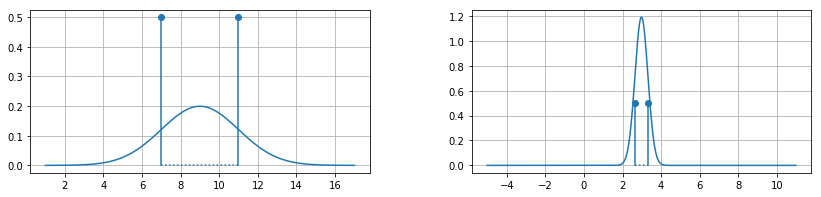

In [7]:
def fx(x):
    return np.sqrt(x)

xbar = 9
P = 4
n = 1

xtilde = np.array([np.sqrt(n*P), -np.sqrt(n*P)])
xi = xbar + xtilde
yi = fx(xi)
y = np.mean(yi)
Py = np.mean((y-yi)**2)
print('Transformovaná distribuce: ({0:.2g}, {1:.2g})'.format(y, Py))

plt.figure(figsize=(14,3))
xx = np.linspace(xbar-4*np.sqrt(P), xbar+4*np.sqrt(P), 1000)
plt.subplot(121)
plt.plot(xx, norm.pdf(xx, loc=xbar, scale=np.sqrt(P)))
plt.stem(xi, np.ones_like(xi)/xi.size, basefmt='C0:')
plt.subplot(122)
xx = np.linspace(y-4*np.sqrt(P), y+4*np.sqrt(P), 1000)
plt.stem(yi, np.ones_like(xi)/xi.size, basefmt='C0:')
plt.plot(xx, norm.pdf(xx, loc=y, scale=np.sqrt(Py)))
plt.show()

Rozdíly mezi analytickým zobrazením, linearizací v EKF a UT v UKF ukazuje následující obrázek:

![ekfukf](img/ekfukf.jpg)
(zdroj: E.A. Wan & R. van der Merwe)

# Unscented Kalman filter - UKF

UKF je typ filtru, který využívá výše uvedenou transformaci k reprezentaci distribuce stavu $x_t$. Budeme uvažovat model

$$
\begin{align}
x_t &= f_t(x_{t-1}, u_t) + w_t, &w_t\sim(0,Q_t)\\
y_t &= h_t(x_t) + v_t, &v_t\sim(0,R_t)
\end{align}
$$

## Algoritmus UKF

**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    - Inicializace sigma-bodů
$$
\begin{align}
\hat{x}_{t-1}^{(i)} &= \hat{x}_{t-1}^+ + \tilde{x}^{(i)}, &i=1,\ldots,2n,\\
\tilde{x}^{(i)} &= \left( \sqrt{nP_{t-1}^+} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{nP_{t-1}^+} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

    - Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{(i)} &= f_t\left(\hat{x}_{t-1}^{(i)}, u_t\right),\\
\hat{x}_t^- &= \frac{1}{2n} \sum_{i=1}^{2n} \hat{x}_t^{(i)},\\
P_t^- &= \frac{1}{2n} \sum_{i=1}^{2n} 
\left(\hat{x}_t^{(i)} - \hat{x}_t^-\right)
\left(\hat{x}_t^{(i)} - \hat{x}_t^-\right)^\intercal
+ Q_t
\end{align}
$$

    - Volitelná reinicializace sigma-bodů pro korekci
$$
\begin{align}
\hat{x}_{t}^{(i)} &= \hat{x}_{t}^- + \tilde{x}^{(i)}, &i=1,\ldots,2n,\\
\tilde{x}^{(i)} &= \left( \sqrt{nP_{t}^-} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{nP_{t}^-} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

    - Korekce (datový update) stavů pozorováním
$$
\begin{aligned}
\hat{y}_t^{(i)} &= h_t\left(\hat{x}_t^{(i)}\right) \\
\hat{y}_t &= \frac{1}{2n} \sum_{i=1}^{2n} \hat{y}_t^{(i)}\\
P_y &= \frac{1}{2n}\sum_{i=1}^{2n} 
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)^\intercal + R_t \\
P_{xy} &= \frac{1}{2n}\sum_{i=1}^{2n} 
\left( \hat{x}_t^{(i)} - \hat{x}_t^- \right)
\left( \hat{y}_t^{(i)} - \hat{y}_t \right)^\intercal \\
\ & \\
K_t &= P_{xy}P_y^{-1} \\
\hat{x}_t^+ &= \hat{x}_{t}^{-} + K_t\left[y_t - \hat{y}_t\right]\\
P_t^{+} &= P_t^- - K_t P_y K_t^\intercal.
\end{aligned}
$$

Pozn.: Vztahy pro $K_t$ a $P_t^+$ vycházejí z ekvivalentní formulace standardního lineárního Kalmanova filtru. Jeho rovnice je totiž možné zapsat několika způsoby.

#### Neaditivní šum

Je-li šum stejně jako v našem prvním EKF neaditivní a stavový model má tvar

$$
\begin{align}
x_t &= f_t(x_{t-1}, u_t, w_t), \\
y_t &= h_t(x_t, v_t),
\end{align}
$$

je UKF filtr možné rovněž použít. Použijeme rozšířený ('augmented') stavový vektor v podobě

$$
x_{a,t} =
\begin{bmatrix}
x_t \\ w_t \\ v_t
\end{bmatrix}
$$

a filtr inicializujeme s parametry

$$
\hat{x}_{a,0}^+ =
\begin{bmatrix}
\hat{x}_0^+ \\ 0 \\ 0
\end{bmatrix},
\qquad
P_{a,0}^+ =
\begin{bmatrix}
P_0^+ & 0 & 0 \\
0 & Q_0 & 0 \\
0 & 0 & R_0
\end{bmatrix}.
$$

V rovnicích výše potom nebudou $Q_t$ a $R_t$ na pravých stranách.

## Obecná UT

Jiná varianta, jak vybírat sigma-body, spočívá v obecné unscented transformaci. Ta vybírá $2n+1$ bodů následovně:

$$
\begin{align}
x^{(0)} &= \bar{x} & \\
x^{(i)} &= \bar{x} + \tilde{x}^{(i)} &i=1,\ldots,2n, \\
\tilde{x}^{(i)} &= \left( \sqrt{(n+\lambda)P} \right)_{i}^\intercal &i=1,\ldots,n,\\
\tilde{x}^{(n+i)} &= -\left( \sqrt{(n+\lambda)P} \right)_{i}^\intercal &i=1,\ldots,n.
\end{align}
$$

Váhy jsou potom

$$
\begin{align}
W^{(0)} &= \frac{\lambda}{n+\lambda} \\
W^{(1)} &= \frac{\lambda}{2(n+\lambda)} \\
\end{align}
$$

Označme stejně jako výše

$$
y^{(i)} = h\left(x^{(i)}\right), \qquad i=1,\ldots,2n.
$$

Výsledná aproximovaná střední hodnota a kovariance jsou

$$
\begin{align}
\bar{y}_u &= \sum_{i=0}^{2n} W^{(i)} y^{(i)} \\
P_u &= \sum_{i=0}^{2n} W^{(i)} 
\left(y^{(i)} - \bar{y}_u \right)
\left(y^{(i)} - \bar{y}_u \right)^\intercal.
\end{align}
$$

Pokud $\lambda=0$, dostaneme vztahy z výše první uvedené transformace (indexované ovšem od nuly). Nenulové hodnoty umožňují potenciálně snižovat chyby vyšších řádů v Taylorově rozvoji. Například $\lambda=3-n$ bude při normalitě $x$ minimalizovat chyby ve čtvrtém řádu.

Zkusme ještě jednou příklad s transformací jako výše.

Transformovaná distribuce: (3, 0.075)


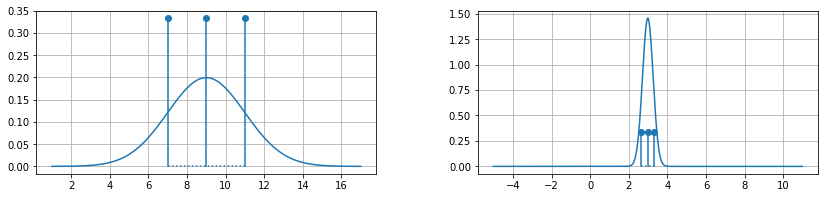

In [4]:
"""
def fx(x):
    return np.sqrt(x)

xbar = 9
P = 4
n = 1
"""
xtilde = np.array([0, np.sqrt(n*P), -np.sqrt(n*P)])
xi = xbar + xtilde
yi = fx(xi)
y = np.mean(yi)
Py = np.mean((y-yi)**2)
print('Transformovaná distribuce: ({0:.2g}, {1:.2g})'.format(y, Py))

plt.figure(figsize=(14,3))
xx = np.linspace(xbar-4*np.sqrt(P), xbar+4*np.sqrt(P), 1000)
plt.subplot(121)
plt.plot(xx, norm.pdf(xx, loc=xbar, scale=np.sqrt(P)))
plt.stem(xi, np.ones_like(xi)/xi.size, basefmt='C0:')
plt.subplot(122)
xx = np.linspace(y-4*np.sqrt(P), y+4*np.sqrt(P), 1000)
plt.stem(yi, np.ones_like(xi)/xi.size, basefmt='C0:')
plt.plot(xx, norm.pdf(xx, loc=y, scale=np.sqrt(Py)))
plt.show()

## Van der Merweho varianta

Van der Merwe navrhl v současné době pravděpodobně nejpoužívanější variantu vah. Ta má olišná počáteční nastavení vah pro stavy (S) a kovarianci (C). Váhy jsou laděny s pomocí parametrů $\alpha, \beta$ a $\kappa$ s hodnotami typicky 0.001, 2 a 0. Tyto parametry určují rozptýlení sigma-bodů. Někdy může být výhodné je nechat více rozptýlit, aby byly zachyceny případné silnější nelinearity.

$$
\begin{align}
W_S^{(0)} &= \frac{\lambda}{n+\lambda}, \\
W_C^{(0)} &= \frac{\lambda}{n+\lambda} + (1-\alpha^2+beta), \\
W_S^{(i)}=W_C^{(i)} &= \frac{1}{2(n+\lambda)}, \\
\end{align}
$$

kde

$$
\lambda = \alpha^2(n+\kappa) - n.
$$

Existuje celá řada publikací zabývajících se nastavením UKF, některé cílící na výpočetní nenáročnost, jiné na minimalizaci chyb aproximace atd.